## 单输入 & 多输出

单输入多输出有一下几个常见应用：
* 1.输入一张图片，输出图片类型【输出1】和作者【输出2】。
* 2.输入一段文字，输出文字态度【输出1】和是否是陈述句【输出2】。  

这里是例子1

In [1]:
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt

## 加载数据

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

author_train = np.array([1 if x>4 else 0 for x in y_train])     # 定义了一个‘作者’，y值大于4则为1，否则为0
x_trian = x_train / 255.0
y_train = to_categorical(y_train, num_classes=10)

In [3]:
author_train.shape, y_train.shape

((60000,), (60000, 10))

## 模型主体

当出现多输入、多输出问题的时候一定要进行层命名，否则很容易混淆

In [4]:
input_layer = Input(shape=(28, 28, 1), name='input_layer')

conv_1 = Conv2D(32, 3, padding='same', activation='relu')(input_layer)
conv_2 = Conv2D(64, 3, padding='same', activation='relu')(conv_1)
maxp_1 = MaxPooling2D()(conv_2)

conv_3 = Conv2D(64, 3, padding='same', activation='relu')(maxp_1)
conv_4 = Conv2D(32, 3, padding='same', activation='relu')(conv_3)
maxp_2 = MaxPooling2D()(conv_4)

conv_5 = Conv2D(32, 3, padding='same', activation='relu')(maxp_2)
conv_6 = Conv2D(16, 3, padding='same', activation='relu')(conv_5)
maxp_3 = MaxPooling2D()(conv_6)

flatten = Flatten()(maxp_3)
dense_1 = Dense(32, activation='relu')(flatten)
dense_out_1 = Dense(10, activation='softmax', name='cate_out')(dense_1)
dense_out_2 = Dense(1, activation='sigmoid', name='author_out')(dense_1)

实际上对于二分类而言sigmoid和softmax是等价的。  
在Quict Start中我并不希望初学者在激活函数上耽误太多时间，面对较大项目的时候二者会存在差异，这将在Advance中详细对比。  

在当前文件夹下可以认为二分类用sigmoid，多分类用softmax。  

实际上，如果将最后一行改成 dense_out_2 = Dense(2,...)(...)，同时在‘加载数据’中添加：  
author_train = to_categorical(author_train, num_classes=2)的话，这里需要改使用softmax。  

模型中使用不同的激活函数是为了告诉初学者模型支持多种激活函数，甚至只要你愿意，在卷积层都可以使用softmax

In [5]:
model = Model(inputs=input_layer, outputs=[dense_out_1, dense_out_2])

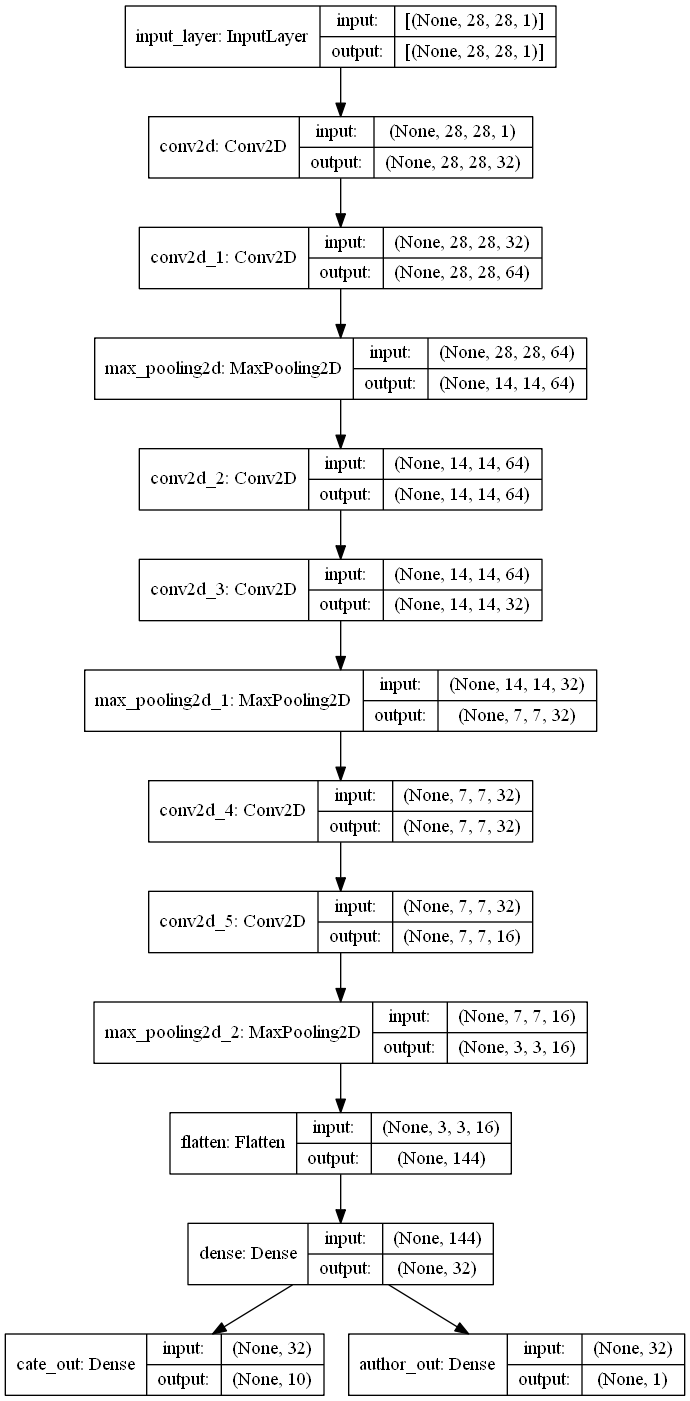

In [6]:
plot_model(model, show_shapes=True)

## 编译模型

编译模型的时候可以指定不同的损失函数，二分类用binary_crossentropy，多分类用categorical_crossentropy

In [7]:
model.compile(
    loss={'cate_out': 'categorical_crossentropy',
          'author_out': 'binary_crossentropy'},
    optimizer='adam',
    metrics='accuracy'
)

## 训练模型

训练模型的时候要明确输入和输出。  
这个案例中两个输出并不是截断输出，都是有标签的输出。

In [8]:
model.fit(
    {'input_layer':x_train},
    {'cate_out':y_train, 'author_out':author_train},
    epochs=5,
    batch_size=512,
    verbose=1
)

Epoch 1/5
118/118 [==============================] - 11s 71ms/step - loss: 2.5629 - cate_out_loss: 1.9050 - author_out_loss: 0.6579 - cate_out_accuracy: 0.4722 - author_out_accuracy: 0.7038 1s - loss: 2.8111 - cate_out_loss: 2.0945 - author_out_loss: 0.7165 - cate_out_accuracy: 0.4261 - author
Epoch 2/5
118/118 [==============================] - 8s 68ms/step - loss: 0.3116 - cate_out_loss: 0.2027 - author_out_loss: 0.1089 - cate_out_accuracy: 0.9398 - author_out_accuracy: 0.9623
Epoch 3/5
118/118 [==============================] - 8s 68ms/step - loss: 0.1627 - cate_out_loss: 0.1075 - author_out_loss: 0.0552 - cate_out_accuracy: 0.9687 - author_out_accuracy: 0.9805
Epoch 4/5
118/118 [==============================] - 8s 67ms/step - loss: 0.1130 - cate_out_loss: 0.0743 - author_out_loss: 0.0387 - cate_out_accuracy: 0.9768 - author_out_accuracy: 0.9865
Epoch 5/5
118/118 [==============================] - 8s 67ms/step - loss: 0.0833 - cate_out_loss: 0.0544 - author_out_loss: 0.0289 - cate_

## 检查

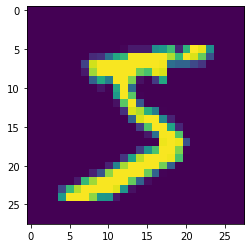

In [9]:
plt.imshow(x_train[0])

In [10]:
author_train[0]

1

In [11]:
score = model.predict(x_train[0:1])

In [12]:
score

[array([[5.80269727e-07, 1.24126998e-09, 9.67295910e-10, 1.13929964e-04,
         5.70991532e-10, 9.99327779e-01, 6.10140778e-05, 1.28412649e-08,
         1.25171035e-04, 3.71595990e-04]], dtype=float32),
 array([[0.99980265]], dtype=float32)]

查看socre输出值就能发现：  
在分类中概率最大的索引是 5，概率为 9.99327779e-0；  
在作者中概率最大的索引是 1，概率为 0.99980265；  
这与输入一致